In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from mtrain.smallnet.predict import tile_image_and_predict
import matplotlib.pyplot as plt
from pathlib import Path

DS = Path("../../datasets/")
BASE_DS_DIR = DS / "T004-taco-crops"
EXP_BASE = BASE_DS_DIR / PROJECT_CODE
OUTS = BASE_DS_DIR / "synth"
LOG_BASE = EXP_BASE / "log"
TACO_BASE_DIR = Path("/Users/hariomnarang/Desktop/personal/TACO/data/")
ANN_FILE = TACO_BASE_DIR / "annotations.json"
TEST_BIG_IMG = BASE_DS_DIR / "14325.jpeg"


TEST_BIG_IMG = BASE_DS_DIR / "14325.jpeg"
res = tile_image_and_predict(TEST_BIG_IMG, learner, FILE_SIZE)
plt.imsave(EXP_BASE / "res.png", res)


In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random

In [6]:
PROJECT_CODE = "004"
NUM_SAMPLES = 5000
TFMS = {
    # "do_flip": True,
    # "flip_vert": True,
    # "max_rotate": 360,
    # "max_zoom": 1.2,
    # "max_lighting": 0.4,
    # "max_warp": 0.2,
}

DS = Path("../../datasets/")
BASE_DS_DIR = DS / "T004-taco-crops"
EXP_BASE = BASE_DS_DIR / PROJECT_CODE
OUTS = BASE_DS_DIR / "synth"
LOG_BASE = EXP_BASE / "log"
TACO_BASE_DIR = Path("/Users/hariomnarang/Desktop/personal/TACO/data/")
ANN_FILE = TACO_BASE_DIR / "annotations.json"
TEST_BIG_IMG = BASE_DS_DIR / "14325.jpeg"

LOG_BASE.mkdir(parents=True, exist_ok=True)
DS.exists(), TACO_BASE_DIR.exists(), ANN_FILE.exists()

(True, True, True)

# Generate Data

In [4]:
# generate data first

from mtrain.smallnet import extract_all

In [7]:
extract_all(TACO_BASE_DIR, ANN_FILE, OUTS, 50, NUM_SAMPLES)

existing samples: 5000
remaining (will generate): 0
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


Generating samples: 0iteration [00:00, ?iteration/s]

total cycles: 0


# Training

(1000, 4000)

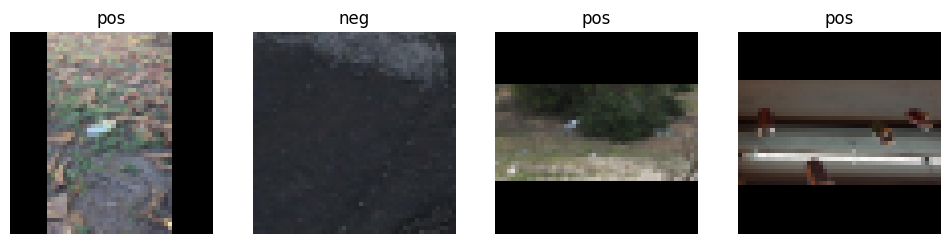

In [10]:
from fastai.vision.all import (
    DataBlock,
    CategoryBlock,
    ImageBlock,
    get_image_files,
    RandomSplitter,
    parent_label,
    aug_transforms,
    Resize,
)

def _get_files(limit):
    def wrapped(path):
        ls = get_image_files(path)
        random.shuffle(ls)
        return ls[:limit]
    return wrapped

dbl = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=_get_files(NUM_SAMPLES),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    batch_tfms=aug_transforms(**TFMS),
    item_tfms=Resize(50),
)


dls = dbl.dataloaders(OUTS, path=LOG_BASE)
dls.valid.show_batch(max_n=4, nrows=1)
len(dls.valid_ds), len(dls.train_ds)

In [12]:
from fastai.vision.all import (
    vision_learner,
    mobilenet_v3_small,
    mobilenet_v3_large,
    CrossEntropyLossFlat,
)
from fastai.callback.progress import CSVLogger, Recorder, ProgressCallback

In [13]:
learner = vision_learner(dls, mobilenet_v3_small, normalize=True, pretrained=True, loss_func=CrossEntropyLossFlat())
learner = learner.remove_cbs([ProgressCallback])
learner = learner.add_cb(CSVLogger)

/Users/hariomnarang/Desktop/personal/roads/mtrain/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hariomnarang/Desktop/personal/roads/mtrain/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
learner.fine_tune(10)

[0, 0.7253929972648621, 1.596329927444458, '00:13']
[0, 0.5018258690834045, 1.0807316303253174, '00:15']
[1, 0.45290255546569824, 0.7275047898292542, '00:17']
[2, 0.42382752895355225, 0.6015066504478455, '00:12']
[3, 0.36776331067085266, 0.3815802037715912, '00:11']
[4, 0.35053685307502747, 0.3022400736808777, '00:09']
[5, 0.31921011209487915, 0.26865604519844055, '00:09']
[6, 0.29385584592819214, 0.2554783523082733, '00:10']
[7, 0.2920357584953308, 0.24358662962913513, '00:14']
[8, 0.2740962505340576, 0.23748861253261566, '00:13']
[9, 0.26626020669937134, 0.2381354570388794, '00:12']


In [15]:
learner.unfreeze()
learner.fit_one_cycle(10, lr_max=slice(1e-6, 1e-4))

[0, 0.2750287353992462, 0.2373674064874649, '00:12']
[1, 0.2727554142475128, 0.23845402896404266, '00:11']
[2, 0.2720186710357666, 0.23503261804580688, '00:16']
[3, 0.270375519990921, 0.23066140711307526, '00:16']
[4, 0.26051583886146545, 0.2316150665283203, '00:09']
[5, 0.26792728900909424, 0.23112550377845764, '00:11']
[6, 0.2686636745929718, 0.23065882921218872, '00:09']
[7, 0.2588561475276947, 0.22997146844863892, '00:10']
[8, 0.25798648595809937, 0.23031960427761078, '00:09']
[9, 0.2593875825405121, 0.2306274026632309, '00:09']


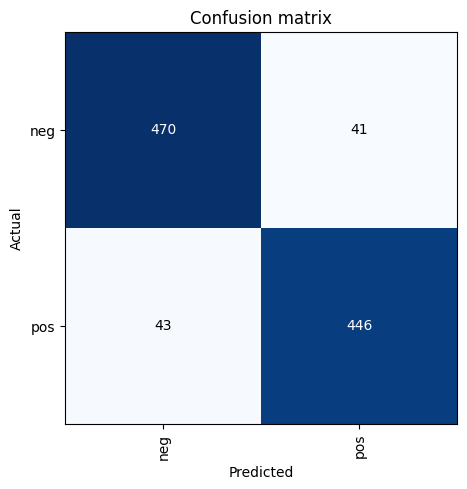

In [16]:
from fastai.vision.all import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

('neg', tensor(0), tensor([0.5425, 0.4575]))


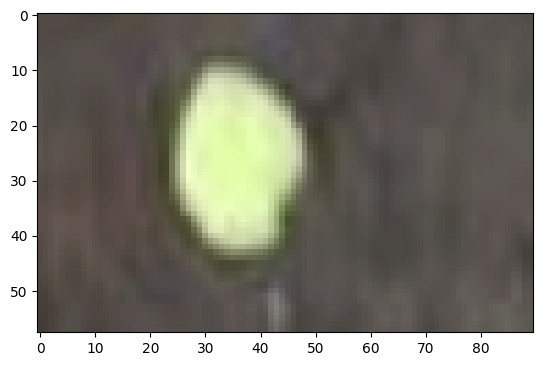

In [17]:
testimg = "/Users/hariomnarang/Desktop/test-img-3.png"
plt.imshow(plt.imread(testimg))
print(learner.predict(testimg))

In [18]:
learner.remove_cb(CSVLogger)
learner.export()

In [19]:
from fastai.vision.all import load_learner
learner = load_learner(LOG_BASE / "export.pkl")
print(learner.path)

../../datasets/T004-taco-crops/004/log


/Users/hariomnarang/Desktop/personal/roads/mtrain/.venv/lib/python3.12/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


100%|██████████| 336/336 [00:22<00:00, 14.85it/s]


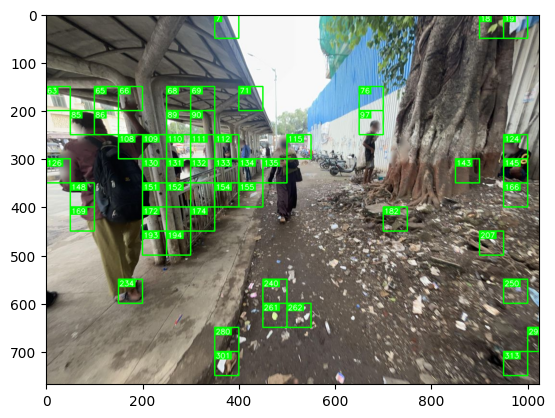

In [20]:
from mtrain.smallnet.predict import tile_image_and_predict

res = tile_image_and_predict(TEST_BIG_IMG, learner)
plt.imsave(EXP_BASE / "res.png", res)
plt.imshow(res)
plt.show()